# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load and Preprocess dataset

In [2]:
df = pd.read_csv('Biotech_preprocessed_dataset_with_outliers.csv')
# df = pd.read_csv('Biotech_preprocessed_dataset_without_outliers.csv')
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = df['Time'].dt.date
df.set_index('Date', inplace=True)
df

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-01-04,2024-01-04 15:00:00,15:00:00,15,Thursday,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 16:00:00,16:00:00,16,Thursday,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 17:00:00,17:00:00,17,Thursday,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 18:00:00,18:00:00,18,Thursday,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 19:00:00,19:00:00,19,Thursday,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,2024-07-08 05:00:00,05:00:00,5,Monday,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 06:00:00,06:00:00,6,Monday,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 07:00:00,07:00:00,7,Monday,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False


In [3]:
# Keep the rows belonging to Sping season only (March, april, and May)
start_date = pd.to_datetime('2024-03-01')
end_date = pd.to_datetime('2024-06-01')

df_spring = df[(df['Time'] >= start_date) & (df['Time'] < end_date)]
df_spring

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-01,2024-03-01 00:00:00,00:00:00,0,Friday,792.0,410.0,198.0,184.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 01:00:00,01:00:00,1,Friday,733.0,222.0,326.0,185.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 02:00:00,02:00:00,2,Friday,706.0,222.0,300.0,184.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 03:00:00,03:00:00,3,Friday,684.0,302.0,197.0,185.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 04:00:00,04:00:00,4,Friday,784.0,400.0,199.0,185.0,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,2024-05-31 19:00:00,19:00:00,19,Friday,1070.0,702.0,194.0,174.0,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 20:00:00,20:00:00,20,Friday,689.0,212.0,295.0,182.0,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 21:00:00,21:00:00,21,Friday,718.0,213.0,322.0,183.0,True,False,False,False,False,False,False,False


In [4]:
df_spring.describe()

,Time,Hour,Total (W),Phase_A (W),Phase_B (W),Phase_C (W)
count,2208,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,2024-04-15 23:30:00,11.500000,1174.199728,643.772192,343.756341,186.619112
min,2024-03-01 00:00:00,0.000000,371.000000,76.000000,109.000000,92.000000
25%,2024-03-23 23:45:00,5.750000,757.750000,316.750000,210.000000,116.000000
50%,2024-04-15 23:30:00,11.500000,958.500000,455.000000,294.000000,183.000000
75%,2024-05-08 23:15:00,17.250000,1302.250000,780.250000,363.000000,186.000000
max,2024-05-31 23:00:00,23.000000,6818.000000,6390.000000,2248.000000,3682.000000
std,NaN,6.923755,792.425590,653.310162,233.842126,126.651852


In [5]:
# df_holiday = df[df['Holiday'] == True]
df_holiday = df_spring[df_spring['Holiday'] == True]
df_holiday

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-02,2024-03-02 00:00:00,00:00:00,0,Saturday,755.0,187.0,384.0,184.0,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 01:00:00,01:00:00,1,Saturday,620.0,232.0,203.0,185.0,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 02:00:00,02:00:00,2,Saturday,800.0,307.0,309.0,184.0,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 03:00:00,03:00:00,3,Saturday,801.0,418.0,199.0,184.0,False,False,True,False,False,False,False,True
2024-03-02,2024-03-02 04:00:00,04:00:00,4,Saturday,710.0,330.0,196.0,184.0,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28,2024-05-28 19:00:00,19:00:00,19,Tuesday,1368.0,902.0,284.0,182.0,False,False,False,False,False,True,False,True
2024-05-28,2024-05-28 20:00:00,20:00:00,20,Tuesday,1533.0,1051.0,299.0,183.0,False,False,False,False,False,True,False,True
2024-05-28,2024-05-28 21:00:00,21:00:00,21,Tuesday,899.0,395.0,321.0,183.0,False,False,False,False,False,True,False,True


In [6]:
# df_office_day = df[df['Holiday'] == False]
df_office_day = df_spring[df_spring['Holiday'] == False]
df_office_day

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-03-01,2024-03-01 00:00:00,00:00:00,0,Friday,792.0,410.0,198.0,184.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 01:00:00,01:00:00,1,Friday,733.0,222.0,326.0,185.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 02:00:00,02:00:00,2,Friday,706.0,222.0,300.0,184.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 03:00:00,03:00:00,3,Friday,684.0,302.0,197.0,185.0,True,False,False,False,False,False,False,False
2024-03-01,2024-03-01 04:00:00,04:00:00,4,Friday,784.0,400.0,199.0,185.0,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,2024-05-31 19:00:00,19:00:00,19,Friday,1070.0,702.0,194.0,174.0,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 20:00:00,20:00:00,20,Friday,689.0,212.0,295.0,182.0,True,False,False,False,False,False,False,False
2024-05-31,2024-05-31 21:00:00,21:00:00,21,Friday,718.0,213.0,322.0,183.0,True,False,False,False,False,False,False,False


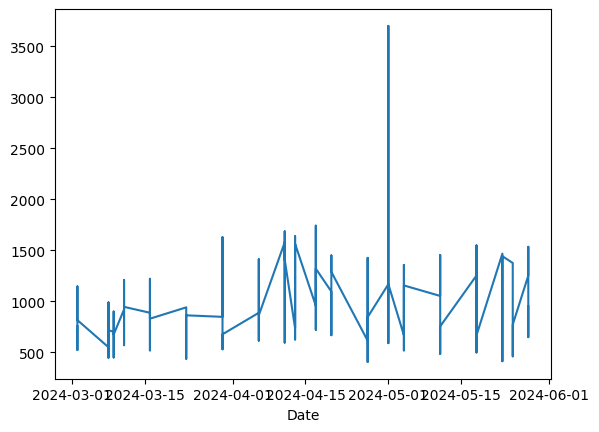

In [7]:
df_holiday['Total (W)'].plot()
plt.show()

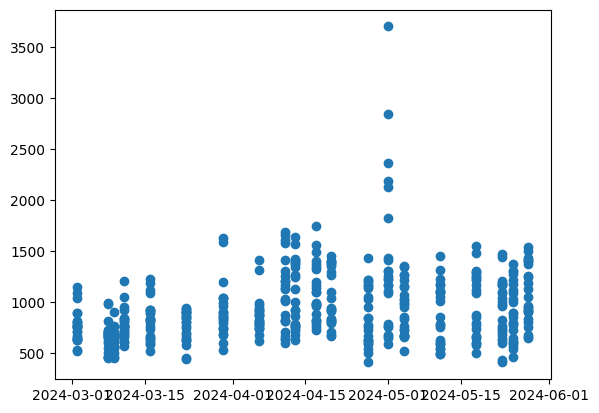

In [8]:
plt.scatter(df_holiday.index, df_holiday['Total (W)'])
plt.show()

<Axes: xlabel='Date'>

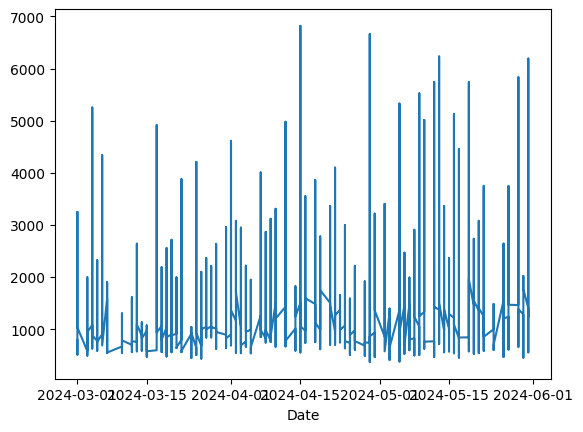

In [9]:
df_office_day['Total (W)'].plot()

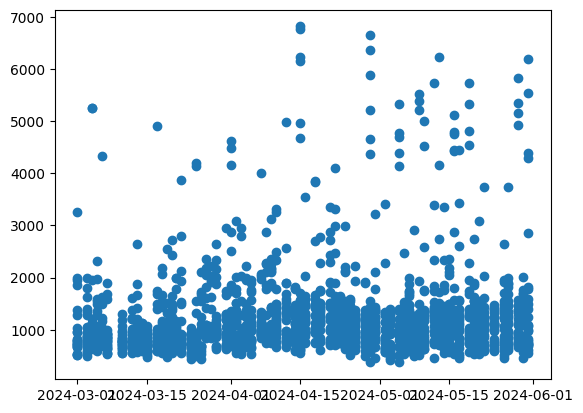

In [10]:
plt.scatter(df_office_day.index, df_office_day['Total (W)'])
plt.show()

In [11]:
print(df_holiday['Total (W)'].mean())
print(df_office_day['Total (W)'].mean())

919.8145833333333
1244.8622685185185


**Drop Unnecessary columns** \
We are going to forecast total load based only on the previous values of total load. So, we wiil keep only the 'Total (W)' column.

In [12]:
df_office_day = pd.DataFrame(df_office_day['Total (W)'])
df_office_day

,Total (W)
Date,
2024-03-01,792.0
2024-03-01,733.0
2024-03-01,706.0
2024-03-01,684.0
2024-03-01,784.0
...,...
2024-05-31,1070.0
2024-05-31,689.0
2024-05-31,718.0


In [13]:
df_holiday = pd.DataFrame(df_holiday['Total (W)'])
df_holiday

,Total (W)
Date,
2024-03-02,755.0
2024-03-02,620.0
2024-03-02,800.0
2024-03-02,801.0
2024-03-02,710.0
...,...
2024-05-28,1368.0
2024-05-28,1533.0
2024-05-28,899.0


**Scaling**

In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_office_day = scaler.fit_transform(df_office_day)
df_office_day = pd.DataFrame(df_office_day, columns=['Total (W)'])
df_office_day

,Total (W)
0,-0.869397
1,-0.887700
2,-0.896076
3,-0.902901
4,-0.871878
...,...
1723,-0.783155
1724,-0.901349
1725,-0.892353
1726,-0.927098


# Separate train and test data

In [15]:
training_data_len = int(len(df_office_day)*0.6)
validation_data_len = int(len(df_office_day)*0.2)
print(training_data_len)
print(validation_data_len)

train_data = df_office_day[:training_data_len]
validation_data = df_office_day[training_data_len:training_data_len+validation_data_len]
test_data = df_office_day[training_data_len+validation_data_len:]


print(train_data.shape, validation_data.shape, test_data.shape)

1036
345
(1036, 1) (345, 1) (347, 1)


In [16]:
print(train_data['Total (W)'].mean())
print(validation_data['Total (W)'].mean())
print(test_data['Total (W)'].mean())

-0.7493731183819596
-0.7102825041643906
-0.6863299910733004


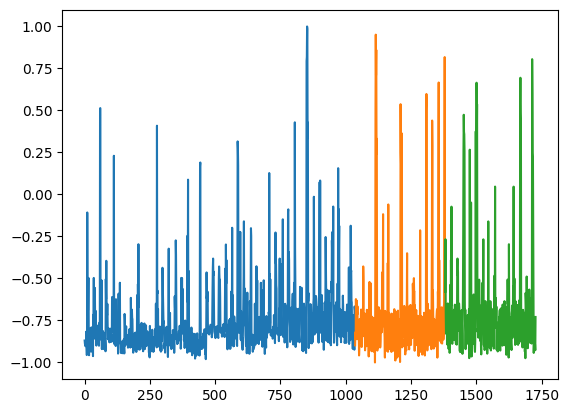

In [17]:
plt.plot(train_data['Total (W)'])
plt.plot(validation_data['Total (W)'])
plt.plot(test_data['Total (W)'])
plt.show()

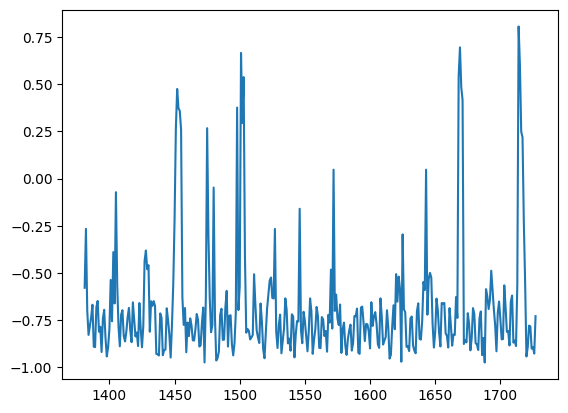

In [18]:
plt.plot(test_data['Total (W)'])
plt.show()

In [19]:
dataset_train = train_data['Total (W)'].values
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape


(1036, 1)

In [20]:
dataset_validation = validation_data['Total (W)'].values
dataset_validation = np.reshape(dataset_validation, (-1, 1))
dataset_validation.shape

(345, 1)

In [21]:
dataset_test = test_data['Total (W)'].values
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(347, 1)

**Create Sequences**

In [22]:
scaled_train, scaled_validation, scaled_test = dataset_train, dataset_validation, dataset_test

In [23]:
a = np.array([1,2,3])
a = np.expand_dims(a, axis=1)
a.shape

(3, 1)

In [24]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train, y_train = np.transpose(X_train, (0, 2, 1)), np.transpose(y_train, (0, 2, 1))

X_train.shape, y_train.shape

((1012, 1, 24), (1012, 1, 24))

In [25]:
X_validation, y_validation = [], []
for i in range(len(scaled_validation)-sequence_length):
  X_validation.append(scaled_validation[i:i+sequence_length])
  y_validation.append(scaled_validation[i+1:i+sequence_length+1])
  # y_train.append(scaled_train[i+sequence_length])

X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_validation, y_validation = np.transpose(X_validation, (0, 2, 1)), np.transpose(y_validation, (0, 2, 1))

X_validation.shape, y_validation.shape

((321, 1, 24), (321, 1, 24))

In [26]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
  # y_test.append(scaled_test[i+sequence_length])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test, y_test = np.transpose(X_test, (0, 2, 1)), np.transpose(y_test, (0, 2, 1))

X_test.shape, y_test.shape

((323, 1, 24), (323, 1, 24))

**Convert to Tensors**

In [27]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

X_validation = torch.tensor(X_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.float32)
print(X_validation.shape, y_validation.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


torch.Size([1012, 1, 24]) torch.Size([1012, 1, 24])
torch.Size([321, 1, 24]) torch.Size([321, 1, 24])
torch.Size([323, 1, 24]) torch.Size([323, 1, 24])


# Create Model

In [301]:
class CNNLSTM(nn.Module):
  def __init__(self, input_features, hidden_size, num_layers, drop_out=0.0):
    super(CNNLSTM, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=64, kernel_size=3, padding='same')
    self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
    self.lstm = nn.LSTM(64, hidden_size, num_layers=1, bias=True, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = self.pool(out)
    out = out.permute(0, 2, 1)
    out, _ = self.lstm(out)
    out = self.fc(out)
    return out


In [302]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [303]:
input_features = 1
num_layers = 1
hidden_size = 200
output_size = 1
drop_out = 0.0968
learning_rate = 0.006805

model = CNNLSTM(input_features, hidden_size, num_layers, drop_out).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')

# optimizer = torch.optim.Adam(model.parameters(), lr=0.00314)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00314)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00314)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.00314)

print(model)

CNNLSTM(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)


**Torch Dataloader**

In [304]:
batch_size = 16
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [305]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([16, 1, 24]), y shape: torch.Size([16, 1, 24])


# Train the Model

In [306]:
num_epochs = 20
train_loss_hist =[]
validation_loss_hist =[]
train_mape_hist = []
validation_mape_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss_train = 0.0
	total_mape_train = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		# preditions = predictions.permute(0,2,1)	# predictions = predictions[:, -1, :]
		# print("predictions: ", predictions.shape)
		batch_y = batch_y.permute(0, 2, 1)
		# print("batch_y: ", batch_y.shape)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss_train += loss.item()
		total_mape_train += torch.mean(torch.abs((predictions[:, -1, :] - batch_y[:, -1, :])/(batch_y[:, -1, :]+1e-8)))*100.0

	# Calculate average training loss and accuracy
	average_loss_train = total_loss_train / len(train_loader)
	train_loss_hist.append(average_loss_train)
	average_mape_train = total_mape_train / len(train_loader)
	train_mape_hist.append(average_mape_train)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_loss_validation = 0.0
		total_mape_validation = 0.0

		for batch_X_validation, batch_y_validation in validation_loader:
			batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
			predictions_validation = model(batch_X_validation).to(device)
			# print("predictions valid: ", predictions_validation.shape)
			batch_y_validation = batch_y_validation.permute(0, 2, 1)
			# print("batch_y valid: ", batch_y_validation.shape)
			# predictions_validation = predictions_validation[:, -1, :]
			validation_loss = loss_fn(predictions_validation, batch_y_validation)

			total_mape_validation += torch.mean(torch.abs((predictions_validation[:, -1, :] - batch_y_validation[:, -1, :])/(batch_y_validation[:, -1, :]+1e-8)))*100.0
			total_loss_validation += validation_loss.item()

		# Calculate average test loss and accuracy
		average_loss_validation = total_loss_validation / len(validation_loader)
		validation_loss_hist.append(average_loss_validation)
		average_mape_validation = total_mape_validation / len(validation_loader)
		validation_mape_hist.append(average_mape_validation)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss_train:.4f}, Validation Loss: {average_loss_validation:.4f}')


Epoch [10/20] - Training Loss: 0.0021, Validation Loss: 0.0084
Epoch [20/20] - Training Loss: 0.0017, Validation Loss: 0.0084


In [307]:
for i in range(len(train_mape_hist)):
  if (i+1) % 10 == 0:
    print(f'Epoch {i+1} - Training MAPE: {train_mape_hist[i]:.2f}, Validation MAPE: {validation_mape_hist[i]:.2f}')

Epoch 10 - Training MAPE: 27.30, Validation MAPE: 38.83
Epoch 20 - Training MAPE: 26.74, Validation MAPE: 39.23


In [308]:
print(f'Training MAPE: {train_mape_hist[-1]:.2f}, Validation MAPE: {validation_mape_hist[-1]:.2f}')

Training MAPE: 26.74, Validation MAPE: 39.23


In [309]:
train_mapes = []
for i in range(len(train_mape_hist)):
  train_mapes.append(train_mape_hist[i].item())

validation_mapes = []
for i in range(len(validation_mape_hist)):
  validation_mapes.append(validation_mape_hist[i].item())

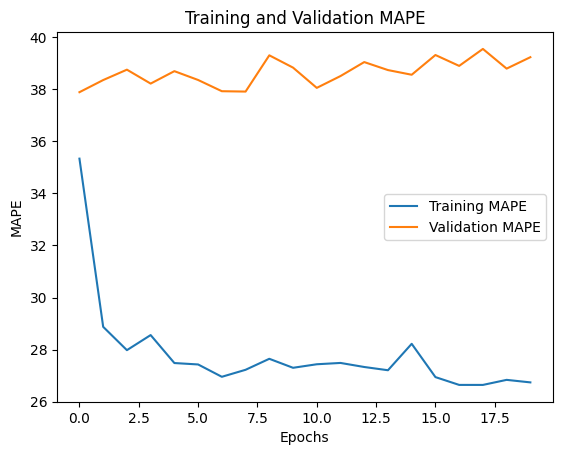

In [310]:
plt.plot(train_mapes, label="Training MAPE")
plt.plot(validation_mapes, label="Validation MAPE")
plt.title("Training and Validation MAPE")
plt.xlabel("Epochs")
plt.ylabel("MAPE")
plt.legend()
plt.show()

# Evaluate on Test Data

In [311]:
actuals_test = np.array([])
predictions_test = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_test, batch_y_test in test_loader:
        batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
        batch_y_test = batch_y_test.permute(0,2,1)
        predictions = model(batch_X_test)
        # print("predictions:", predictions.shape)
        # print("batch_y_test:", batch_y_test.shape)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_test = np.append(predictions_test, predictions[:, -1])

        actuals =  batch_y_test.to('cpu').numpy().squeeze()
        actuals_test = np.append(actuals_test, actuals[:, -1])


In [312]:
# MAPE on test data
print(actuals_test.shape, predictions_test.shape)
relative_abs_error = abs((actuals_test-predictions_test)/actuals_test)
print(f"MAPE on test data = {(np.mean(relative_abs_error)*100.0):.2f}")

(323,) (323,)
MAPE on test data = 40.40


In [313]:
actuals_test = np.expand_dims(actuals_test, axis=1)
actuals_test_original = scaler.inverse_transform(actuals_test)

predictions_test = np.expand_dims(predictions_test, axis=1)
predictions_test_original = scaler.inverse_transform(predictions_test)

pd.DataFrame({'Predicted Power':predictions_test_original.squeeze(), 'Actual Power': actuals_test_original.squeeze()})

,Predicted Power,Actual Power
0,1607.615478,3360.999992
1,1550.068953,1770.000010
2,2703.514321,1062.000023
3,922.052699,729.000064
4,783.559457,1268.999972
...,...,...
318,1213.022618,1069.999972
319,925.929227,688.999935
320,677.009523,717.999918
321,861.983242,606.000058


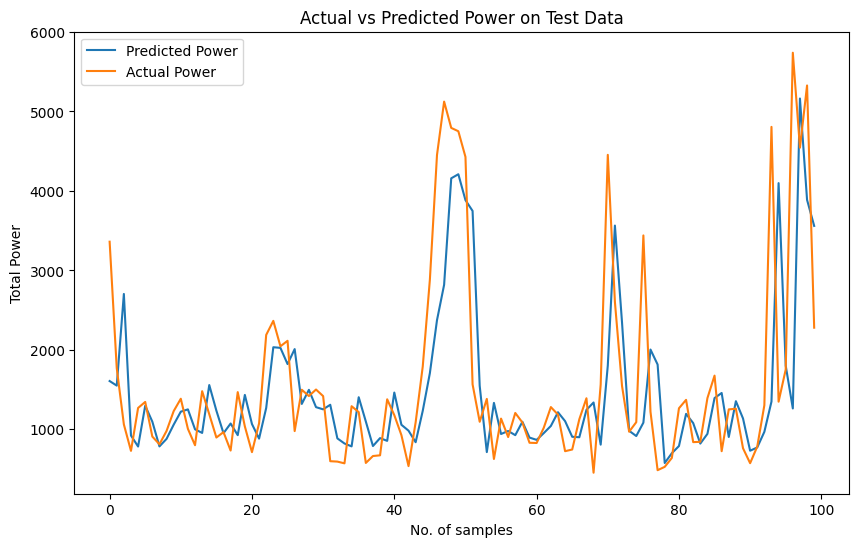

In [314]:
# plot actual vs predicted powers on first test data
plt.figure(figsize=(10, 6))
plt.plot(predictions_test_original[:100], label='Predicted Power')
plt.plot(actuals_test_original[:100], label='Actual Power')
plt.title('Actual vs Predicted Power on Test Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-evaluate on Training Data

In [315]:
actuals_train = np.array([])
predictions_train = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_train, batch_y_train in train_loader:
        batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device)
        batch_y_train = batch_y_train.permute(0,2,1)
        predictions = model(batch_X_train)
        predictions = predictions.to('cpu').detach().numpy().squeeze()
        predictions_train = np.append(predictions_train, predictions[:, -1])

        actuals =  batch_y_train.to('cpu').numpy().squeeze()
        actuals_train = np.append(actuals_train, actuals[:, -1])


In [316]:
# MAPE on training data
relative_abs_error = abs((actuals_train-predictions_train)/actuals_train)
print(f"MAPE on train data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on train data = 26.04


In [317]:
actuals_train = np.expand_dims(actuals_train, axis=1)
actuals_train_original = scaler.inverse_transform(actuals_train)

predictions_train = np.expand_dims(predictions_train, axis=1)
predictions_train_original = scaler.inverse_transform(predictions_train)

pd.DataFrame({'Predicted Power':predictions_train_original.squeeze(), 'Actual Power': actuals_train_original.squeeze()})

,Predicted Power,Actual Power
0,1119.006455,615.000072
1,998.274418,1241.000055
2,1760.484496,1125.999998
3,1481.141469,986.000029
4,2123.110704,1747.000037
...,...,...
1007,1017.305062,767.000061
1008,2683.721859,1742.000093
1009,878.630828,773.000071
1010,1435.155741,2187.999978


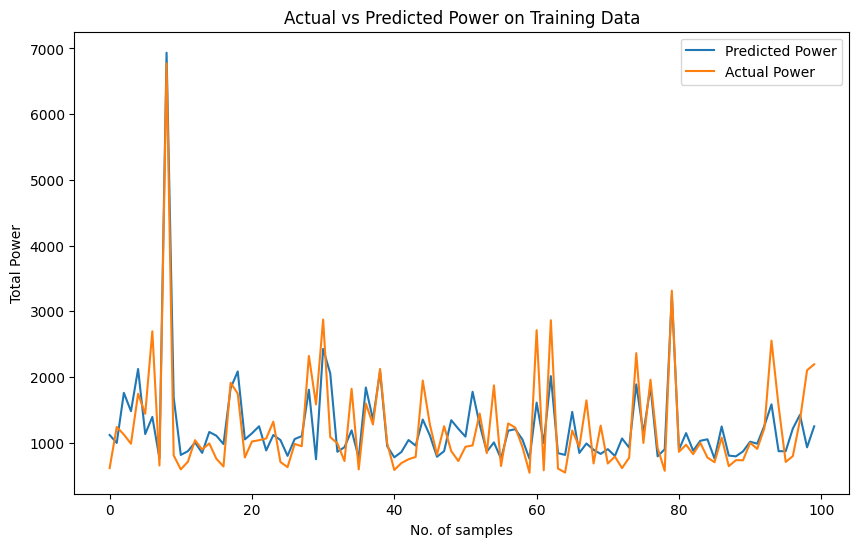

In [318]:
plt.figure(figsize=(10, 6))
plt.plot(predictions_train_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_train_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on Training Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()

# Re-Evaluate on Validation Data

In [319]:
actuals_validation = np.array([])
predictions_validation = np.array([])
# Use no_grad to avoid computing gradients
model.eval()
with torch.no_grad():
    for batch_X_validation, batch_y_validation in validation_loader:
        batch_X_validation, batch_y_validation = batch_X_validation.to(device), batch_y_validation.to(device)
        batch_y_validation = batch_y_validation.permute(0,2,1)
        predictions = model(batch_X_validation)
        predictions = predictions.to('cpu').detach().numpy()[:, :]
        predictions_validation = np.append(predictions_validation, predictions[:, -1])

        actuals =  batch_y_validation.to('cpu').numpy()[:, :]
        actuals_validation = np.append(actuals_validation, actuals[:, -1])


In [320]:
# MAPE on validation dataset
relative_abs_error = abs((actuals_validation-predictions_validation)/actuals_validation)
print(f"MAPE on validation data = {(np.mean(relative_abs_error)*100.0):.2f}")

MAPE on validation data = 32.82


In [321]:
actuals_validation = np.expand_dims(actuals_validation, axis=1)
actuals_validation_original = scaler.inverse_transform(actuals_validation)

predictions_validation = np.expand_dims(predictions_validation, axis=1)
predictions_validation_original = scaler.inverse_transform(predictions_validation)

pd.DataFrame({'Predicted Power':predictions_validation_original.squeeze(), 'Actual Power': actuals_validation_original.squeeze()})

,Predicted Power,Actual Power
0,1287.585246,676.000043
1,895.742230,668.000094
2,893.850271,875.999916
3,1060.802634,1062.000023
4,1152.029757,1194.000044
...,...,...
316,1065.211762,1461.000089
317,1558.505626,1236.999985
318,1133.833750,4153.000018
319,2472.877278,6231.000080


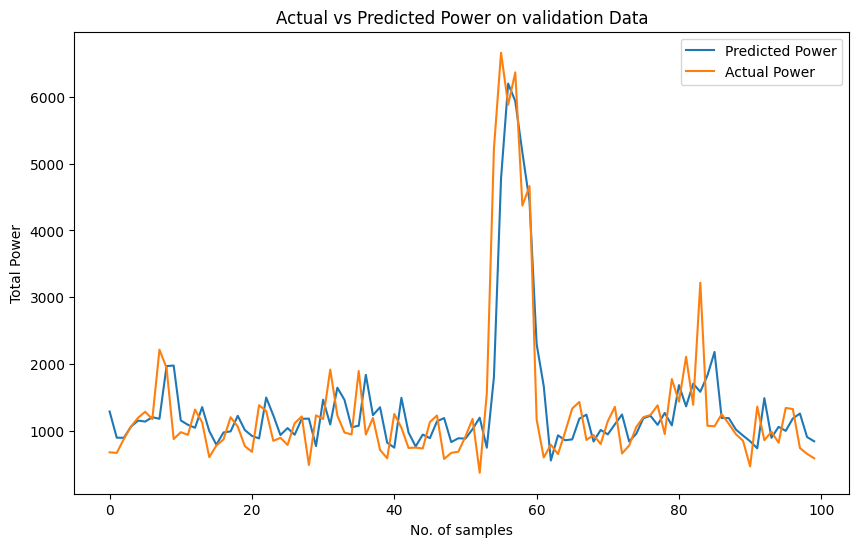

In [322]:
# plot on first 100 validation data
plt.figure(figsize=(10, 6))
plt.plot(predictions_validation_original[:100], label='Predicted Power', linewidth=1.5)
plt.plot(actuals_validation_original[:100], label='Actual Power', linewidth=1.5)
plt.title('Actual vs Predicted Power on validation Data')
plt.xlabel('No. of samples')
plt.ylabel('Total Power')
plt.legend()
plt.show()